## google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## remove all reports

In [ ]:
# import os
# # Specify the root directory where you want to start searching
# root_directory = f"drive/MyDrive/DDEMS Lab/pickle_dataset"

# # Function to remove files with specific prefixes in subdirectories
# def remove_files_with_prefix(root_directory, prefix_list):
#     for foldername, subfolders, filenames in os.walk(root_directory):
#         for filename in filenames:
#             for prefix in prefix_list:
#                 if filename.startswith(prefix):
#                     file_path = os.path.join(foldername, filename)
#                     os.remove(file_path)
#                     print(f"Removed: {file_path}")

# # List of prefixes of files to be removed
# prefix_list = ["Confusion_Matrix", "training_history", "README-RESULTS"]

# # Call the function to remove files
# remove_files_with_prefix(root_directory, prefix_list)


In [ ]:
%ls drive/MyDrive/DDEMS\ Lab/pickle_dataset

output1/  output20/  output4/  output6/  output8/  README-DATASETS.gdoc
output2/  output3/   output5/  output7/  output9/  README-DATASETS.txt


## installation & imports

In [ ]:
# %pip install --upgrade tensorflow

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from sklearn.model_selection import (train_test_split, LeaveOneOut, KFold)
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.layers import (Input, Dense,Conv2D,Dropout,Activation,
                                     BatchNormalization,Flatten,MaxPool2D,)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
tf.config.experimental.set_memory_growth = True

#load pickle files

In [ ]:
def load_data(pickle_dir):

  # Load X_train, X_test, y_train, y_test from pickle files
  with open(pickle_dir + '/X_train_filterd.pkl', 'rb') as f:
      X_train = pickle.load(f)

  with open(pickle_dir + '/X_test_filterd.pkl', 'rb') as f:
      X_test = pickle.load(f)

  with open(pickle_dir + '/y_train_1hot.pkl', 'rb') as f:
      y_train = pickle.load(f)

  with open(pickle_dir + '/y_test_1hot.pkl', 'rb') as f:
      y_test = pickle.load(f)

  print("loaded data :")
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

# balancing dataset

In [ ]:
def balance_dataset(X_train, X_test, y_train, y_test):
    # Concatenate the train and test data
    X_all = np.concatenate((X_train, X_test), axis=0)
    y_all = np.concatenate((y_train, y_test), axis=0)

    # Convert one-hot encoded arrays to integer labels
    y_all_int = np.argmax(y_all, axis=1)

    # Get the number of samples in the minority class
    min_class_samples = min(np.bincount(y_all_int))

    # Shuffle the dataset
    X_all_shuffled, y_all_shuffled = shuffle(X_all, y_all_int, random_state=42)

    # Concatenate the balanced datasets
    X_train_balanced = []; y_train_balanced = []
    X_test_balanced  = []; y_test_balanced  = []
    for class_label in range(13):
        X_class = X_all_shuffled[y_all_shuffled == class_label][:min_class_samples]
        y_class = y_all_shuffled[y_all_shuffled == class_label][:min_class_samples]

        X_train_class_balanced, X_test_class_balanced, y_train_class_balanced, y_test_class_balanced = \
        train_test_split(X_class, y_class, test_size=0.2, random_state=42)

        X_train_balanced.append(X_train_class_balanced)
        y_train_balanced.append(y_train_class_balanced)
        X_test_balanced.append(X_test_class_balanced)
        y_test_balanced.append(y_test_class_balanced)

    X_train_balanced = np.concatenate(X_train_balanced, axis=0)
    y_train_balanced = np.concatenate(y_train_balanced, axis=0)
    X_test_balanced = np.concatenate(X_test_balanced, axis=0)
    y_test_balanced = np.concatenate(y_test_balanced, axis=0)

    # Convert integer labels to one-hot format
    encoder = OneHotEncoder(sparse=False)
    y_train_balanced_onehot = encoder.fit_transform(y_train_balanced.reshape(-1, 1))
    y_test_balanced_onehot = encoder.fit_transform(y_test_balanced.reshape(-1, 1))

    print("Original shapes:")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print("Balanced and Split train/test shapes:")
    print(X_train_balanced.shape, X_test_balanced.shape, y_train_balanced.shape, y_test_balanced.shape)
    print("min_samples:", min_class_samples)

    return X_train_balanced, X_test_balanced, y_train_balanced_onehot, y_test_balanced_onehot

# model

## model 1 implementation

In [ ]:
def train_model(X_train, y_train, epochs=220, batch_size=64):

  ## model's implementation
  model_input = Input(X_train[0].shape) #(13, n, 1) - n is calculated according to the duration of windows and n in mfcc
  x = model_input

  x = Conv2D(512,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(128,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(64,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(32,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Conv2D(16,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.25)(x)

  x = Flatten()(x)
  x = Dense(13,activation="relu")(x)

  model_output = Activation("softmax")(x)
  model = Model(model_input,model_output,name="genre_classifier")
  model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

  ## training model
  hist = model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs)

  return model, hist

## model 2 implementation

In [ ]:
def train_inception_model(X_train, y_train, epochs=220, batch_size=64,learning_rate= 0.0001,
                          genres_dist =[[0, 1, 2, 3, 5, 12],  #'A-Abuata','A-Afshari','A-Bayat-E Kord','A-Bayat-E Tork','A-Dashti','D-Shur'
                                        [9, 11],              #'D-Nava','D-Segah'
                                        [4, 6, 7],            #'A-Bayat-e Esfahan', 'D-Chahargah' 'D-Homayun',
                                        [8, 10]               #'D-Mahoor','D-Rastpanjgah'
                          ], Dropout_value = 0.15,
                          loss_weights = [1]  # List of loss weights
                          ):
  if loss_weights == [1]:
    loss_weights = [1 for _ in range(len(genres_dist))]
  output_partitions = inception_labale_maker(y_train, genres_dist)

  ## model's implementation
  model_input = Input(X_train[0].shape) #(13, n, 1) - n is calculated according to the duration of windows and n in mfcc
  x = model_input

  x = Conv2D(512,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  # x = Dropout(Dropout_value)(x)

  x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  # x = Dropout(Dropout_value)(x)

  x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
  x = Activation("relu")(x)
  # x = Dropout(Dropout_value)(x)

  x = Conv2D(128,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  # x = Dropout(Dropout_value)(x)

  x = Conv2D(64,kernel_size=3,strides=2,padding="same",activation=None)(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
  x = Activation("relu")(x)
  # x = Dropout(Dropout_value)(x)

  branches = []

  for i in range(len(genres_dist)):

      x_branch = Conv2D(32,kernel_size=3,strides=2,padding="same",activation=None)(x)
      x_branch = BatchNormalization()(x_branch)
      x_branch = Activation("relu")(x_branch)
      # x_branch = Dropout(0.25)(x_branch)

      x_branch = Conv2D(16,kernel_size=3,strides=2,padding="same",activation=None)(x_branch)
      x_branch = BatchNormalization()(x_branch)
      x_branch = Activation("relu")(x_branch)
      # x_branch = Dropout(0.25)(x_branch)

      x_branch = Flatten()(x_branch)
      x_branch = Dense(13,activation="relu")(x_branch)

      # Output layer for genre classification
      # output_layer = layers.Dense(len(genres_dist[i]), activation='softmax', name=f'output_layer_{i}')(x_branch)
      output_layer = layers.Dense(len(genres_dist[i]), name=f'output_layer_{i}')(x_branch)

      branches.append(output_layer)


  # Create a model with all branches
  branch_model = keras.Model(inputs=model_input, outputs=branches, name='all_outputs')

  # Define your loss functions
  loss_functions = {f'output_layer_{i}': 'categorical_crossentropy' for i in range(len(genres_dist))}

  # Create a dictionary of loss weights
  loss_weights_dict = {f'output_layer_{i}': loss_weights[i] for i in range(len(genres_dist))}

  # Compile the model with loss weights
  branch_model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss=loss_functions,
                loss_weights=loss_weights_dict,
                metrics=['accuracy'])

  # # Compile the model
  # branch_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  ## training model
  hist = branch_model.fit(X_train, output_partitions, epochs=epochs, batch_size=batch_size)

  # Print model summary
  # model.summary()

  return branch_model, hist

## inception labale maker

In [ ]:
def inception_labale_maker(y, genres_dist):

  partitions = []

  # Create a partition for each genre distribution
  for indices in genres_dist:
      partition = y[:, indices]
      partitions.append(partition)

  # Convert the partitions to NumPy arrays
  partitions = [np.array(partition) for partition in partitions]
  return partitions

## evaluating model

In [ ]:
def evaluate_model(model, hist, X_train, y_train, X_test, y_test, pickle_dis,
                   window_duration = 4, overlap = 0, epochs = 240, batch_size = 64,
                   balansed=False, model_type='normal', genres_dist=[[12],
                                         [0, 1, 2, 3, 5], [9, 11], [4, 7],
                                         [6, 10], [8]
                                        ]
                   ):

  if model_type == 'inception':
    y_train = inception_labale_maker(y_train, genres_dist)
    y_test = inception_labale_maker(y_test, genres_dist)

  train_result = model.evaluate(X_train, y_train)
  test_result = model.evaluate(X_test, y_test)

  # Path to the directory where the README file will be created
  readme_file_path = os.path.join(pickle_dis, 'README-RESULTS.md')

  # Find all existing README files in the directory
  existing_readme_files = [filename for filename in os.listdir(pickle_dis) if filename.startswith('README-RESULTS')]

  # If there are existing README files, find the maximum 'n' in their names
  max_n = 0
  for filename in existing_readme_files:
      try:
          n = int(filename.split('-')[-1].split('.')[0])
          max_n = max(max_n, n)
      except ValueError:
          pass

  # Create a new filename with the maximum 'n' + 1
  new_readme_filename = f'README-RESULTS-{max_n + 1}.md'
  readme_file_path = os.path.join(pickle_dis, new_readme_filename)

  # Write the content to the new README file
  content = f"# model's evaluation Details\n"
  content += "----------------------------------------------------------------\n"
  content += f"model type    : {model_type}\n"
  if model_type=="inception":
    content += f"model has {len(genres_dist)} branches :"
    for i in range (len(genres_dist)):
      content += f"\t branch {i} => {genres_dist[i]}"
    content += "----------------------------------------------------------------\n"
  content += f"window size   : {window_duration}\n"
  content += f"overlap       : {overlap}\n"
  content += f"epochs        : {epochs}\n"
  content += f"batch_size    : {batch_size}\n"
  content += f"train size    : {X_train.shape[0]}\n"
  content += f"test size     : {X_test.shape[0]}\n"
  if(False): content += f"balanced      : NO\n"
  else: content += f"balanced      : YES\n"
  content += "----------------------------------------------------------------\n"
  content += f"train loss and acc   : {train_result}\n"
  content += f"test loss and acc   : {test_result}\n"

  content += "----------------------------------------------------------------\n"
  # Get the training details as a string
  training_details = ""
  training_details += "Training History:\n"
  training_details += "Epoch\tLoss\t\tAccuracy\t\n"
  for epoch in range(len(hist.history['loss'])):
    if model_type == 'inception':
      accuracy_str = ''
      for key, value in hist.history.items():
        if key.endswith("accuracy"):
            accuracy_str += f"{key}: {value[epoch]:.4f}, "
      training_details += f"{epoch+1}\t{hist.history['loss'][epoch]:.4f}\t{accuracy_str}\n"
    else:
      training_details += f"{epoch+1}\t{hist.history['loss'][epoch]:.4f}\t{hist.history['accuracy'][epoch]:.4f}\n"

  # Get the model summary as a string
  model_summary = []
  model.summary(print_fn=lambda x: model_summary.append(x))
  model_summary = "\n".join(model_summary)
  training_details += "Model Summary:\n"
  training_details += model_summary + "\n\n"
  content += "training_details\n"
  content += training_details

  with open(readme_file_path, 'w') as file:
      file.write(content)

  print(f"New README file '{new_readme_filename}' created successfully!")

## ploting loss and accuracy of epoches

In [ ]:
def plot_loss_acc(hist, pickle_dis, model_type='normal'):
  # Convert the history to a DataFrame and plot it
  if model_type=='inception':
    acc_list = []
    for epoch in range(len(hist.history['loss'])):
      acc_list_ep = []
      for key, value in hist.history.items():
        if key.endswith("accuracy"):
            acc_list_ep.append(value[epoch])
      acc_list.append(round(sum(acc_list_ep) / len(acc_list_ep), 2))
    hist.history['accuracy'] = acc_list

  hist_df = pd.DataFrame(hist.history)
  hist_df.plot(figsize=(8, 6))

  # Set plot labels and title
  plt.xlabel('Epochs')
  plt.ylabel('Loss/Accuracy')  # Customize this based on the metrics you have used during training
  plt.title(f'Training History - model {model_type}')

  PNG_file_path = os.path.join(pickle_dis, "training_history.png")

  # Find all existing PNG files in the directory
  existing_PNG_files = [filename for filename in os.listdir(pickle_dis) if filename.startswith('training_history')]

  # If there are existing PNG files, find the maximum 'n' in their names
  max_n = 0
  for filename in existing_PNG_files:
      try:
          n = int(filename.split('-')[-1].split('.')[0])
          max_n = max(max_n, n)
      except ValueError:
          pass

  # Create a new filename with the maximum 'n' + 1
  new_PNG_filename = f'training_history-{max_n + 1}.png'
  PNG_file_path = os.path.join(pickle_dis, new_PNG_filename)

  # Save the plot to a file
  plt.savefig(PNG_file_path)
  print(f"plot saved as : {new_PNG_filename}")
  # Show the plot
  plt.show()

## confusion matrix

In [ ]:
def plot_Confusion_Matrix(model, X_test, y_test, pickle_dis):
  # Define your class labels
  class_labels = ['A-Abuata', 'A-Afshari', 'A-Bayat-E Kord', 'A-Bayat-E Tork',
                  'A-Bayat-e Esfahan', 'A-Dashti', 'D-Chahargah', 'D-Homayun', 'D-Mahoor',
                  'D-Nava', 'D-Rastpanjgah', 'D-Segah', 'D-Shur']

  y_pred_onehot = model.predict(X_test)

  y_true = np.argmax(y_test, axis=1)
  y_pred = np.argmax(y_pred_onehot, axis=1)

  # Compute the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix using seaborn's heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  PNG_file_path = os.path.join(pickle_dis, "Confusion_Matrix.png")

  # Find all existing PNG files in the directory
  existing_PNG_files = [filename for filename in os.listdir(pickle_dis) if filename.startswith('Confusion_Matrix')]

  # If there are existing PNG files, find the maximum 'n' in their names
  max_n = 0
  for filename in existing_PNG_files:
      try:
          n = int(filename.split('-')[-1].split('.')[0])
          max_n = max(max_n, n)
      except ValueError:
          pass

  # Create a new filename with the maximum 'n' + 1
  new_PNG_filename = f'Confusion_Matrix-{max_n + 1}.png'
  PNG_file_path = os.path.join(pickle_dis, new_PNG_filename)

  # Save the plot to a file
  plt.savefig(PNG_file_path)

  plt.show()

## saving the model

In [ ]:
def save_model_to_directory(model, directory, model_name='model', ext='.h5'):
    # Create the output directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Get a list of all files in the directory
    existing_files = os.listdir(directory)

    # Find the maximum n value among the existing files with the same prefix
    existing_n_values = [int(filename[len(model_name)+1:-len(ext)]) for filename in existing_files
                         if filename.startswith(model_name) and filename.endswith(ext)]
    max_n = max(existing_n_values) if existing_n_values else 0

    # Determine the new model file name
    new_model_name = f"{model_name}-{max_n + 1}{ext}"

    # Save the model to the specified directory
    save_path = os.path.join(directory, new_model_name)
    model.save(save_path)

    print(f"Model saved as {new_model_name}")

#calling methods

In [ ]:
dataset_number="9"
window_D_list = [5]
overlap_list = [0]
pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}/filterd"
epochs = 5
batch_size = 96
learning_rate = 0.000001
X_train, X_test, y_train, y_test = load_data(pickle_dis)

loaded data :
(7725, 13, 216, 1) (1932, 13, 216, 1) (7725, 13) (1932, 13)


In [ ]:
output_partitions = inception_labale_maker(y_train, genres_dist)


In [ ]:
genres_dist = [[0, 1, 2, 3, 5, 12], #'A-Abuata','A-Afshari','A-Bayat-E Kord','A-Bayat-E Tork','A-Dashti','D-Shur'
              [9, 11], #'D-Nava','D-Segah'
              [4, 6, 7], #'A-Bayat-e Esfahan', 'D-Chahargah' 'D-Homayun',
              [8, 10] #'D-Mahoor','D-Rastpanjgah'
              ]
loss_weights = [1 for _ in range(len(genres_dist))]

# output_partitions = inception_labale_maker(y_train, genres_dist)

In [ ]:

genres_dist = [[0, 1, 2, 3, 5, 12], #'A-Abuata','A-Afshari','A-Bayat-E Kord','A-Bayat-E Tork','A-Dashti','D-Shur'
              [9, 11], #'D-Nava','D-Segah'
              [4, 6, 7], #'A-Bayat-e Esfahan', 'D-Chahargah' 'D-Homayun',
              [8, 10] #'D-Mahoor','D-Rastpanjgah'
              ]


inc_model, inc_hist = train_inception_model(X_train, y_train, epochs=epochs,
                                            batch_size=batch_size, learning_rate= learning_rate,
                                            genres_dist=genres_dist,
                                            loss_weights=loss_weights)



Epoch 1/5
81/81 [==============================] - 18s 82ms/step - loss: 5.4615 - output_layer_0_loss: 1.9578 - output_layer_1_loss: 0.7035 - output_layer_2_loss: 1.7700 - output_layer_3_loss: 1.0302 - output_layer_0_accuracy: 0.2048 - output_layer_1_accuracy: 0.4663 - output_layer_2_accuracy: 0.1638 - output_layer_3_accuracy: 0.6792
Epoch 2/5
81/81 [==============================] - 7s 84ms/step - loss: 5.4657 - output_layer_0_loss: 1.9532 - output_layer_1_loss: 0.7214 - output_layer_2_loss: 1.7776 - output_layer_3_loss: 1.0134 - output_layer_0_accuracy: 0.1957 - output_layer_1_accuracy: 0.4634 - output_layer_2_accuracy: 0.1641 - output_layer_3_accuracy: 0.6821
Epoch 3/5
81/81 [==============================] - 7s 82ms/step - loss: 5.4201 - output_layer_0_loss: 1.9208 - output_layer_1_loss: 0.7020 - output_layer_2_loss: 1.7780 - output_layer_3_loss: 1.0192 - output_layer_0_accuracy: 0.2016 - output_layer_1_accuracy: 0.4593 - output_layer_2_accuracy: 0.1570 - output_layer_3_accuracy: 0

In [ ]:
evaluate_model(inc_model, inc_hist, X_train, y_train, X_test, y_test, pickle_dis,
                   window_duration = window_D_list[0], overlap = overlap_list[0],
                   epochs = epochs, batch_size = batch_size, balansed=True,
                   model_type='inception', genres_dist=genres_dist)

61/61 [==============================] - 1s 17ms/step - loss: nan - output_layer_0_loss: nan - output_layer_1_loss: nan - output_layer_2_loss: nan - output_layer_3_loss: nan - output_layer_0_accuracy: 0.7412 - output_layer_1_accuracy: 0.9369 - output_layer_2_accuracy: 0.7785 - output_layer_3_accuracy: 0.9389
New README file 'README-RESULTS-10.md' created successfully!


:_)

plot saved as : training_history-9.png


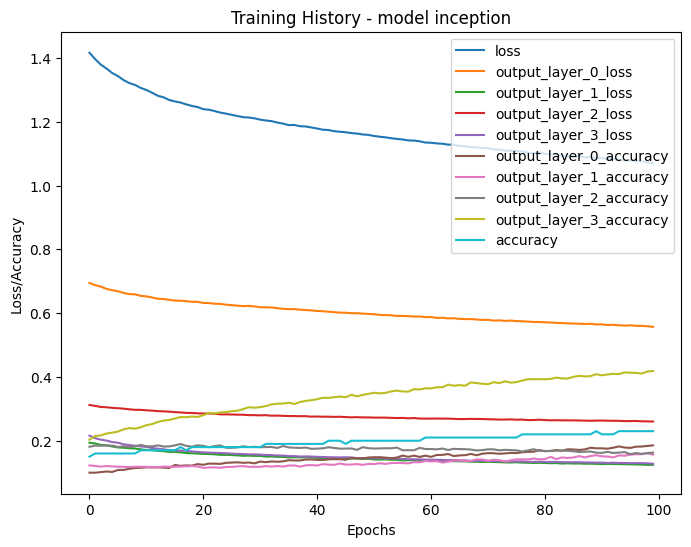

In [ ]:
plot_loss_acc(inc_hist, pickle_dis, model_type='inception')

In [ ]:
def plot_balance(Y_data):

  name = np.array(['A-Abuata', 'A-Afshari', 'A-Bayat-E Kord', 'A-Bayat-E Tork',
                   'A-Bayat-e Esfahan', 'A-Dashti', 'D-Chahargah', 'D-Homayun',
                   'D-Mahoor', 'D-Nava', 'D-Rastpanjgah', 'D-Segah', 'D-Shur'])

  price = (np.unique(Y_data, return_counts=True))[1]
  fig, ax = plt.subplots(figsize =(10, 7))

  # Horizontal Bar Plot
  ax.barh(name, price)

  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)

  # Add x, y gridlines
  ax.grid( color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  # Show top values
  ax.invert_yaxis()

  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold',
              color ='grey')

  # Add Plot Title
  ax.set_title('albume genrs and their number',
              loc ='left', )

  # Show Plot
  plt.show()

In [ ]:
plot_balance(y_train)

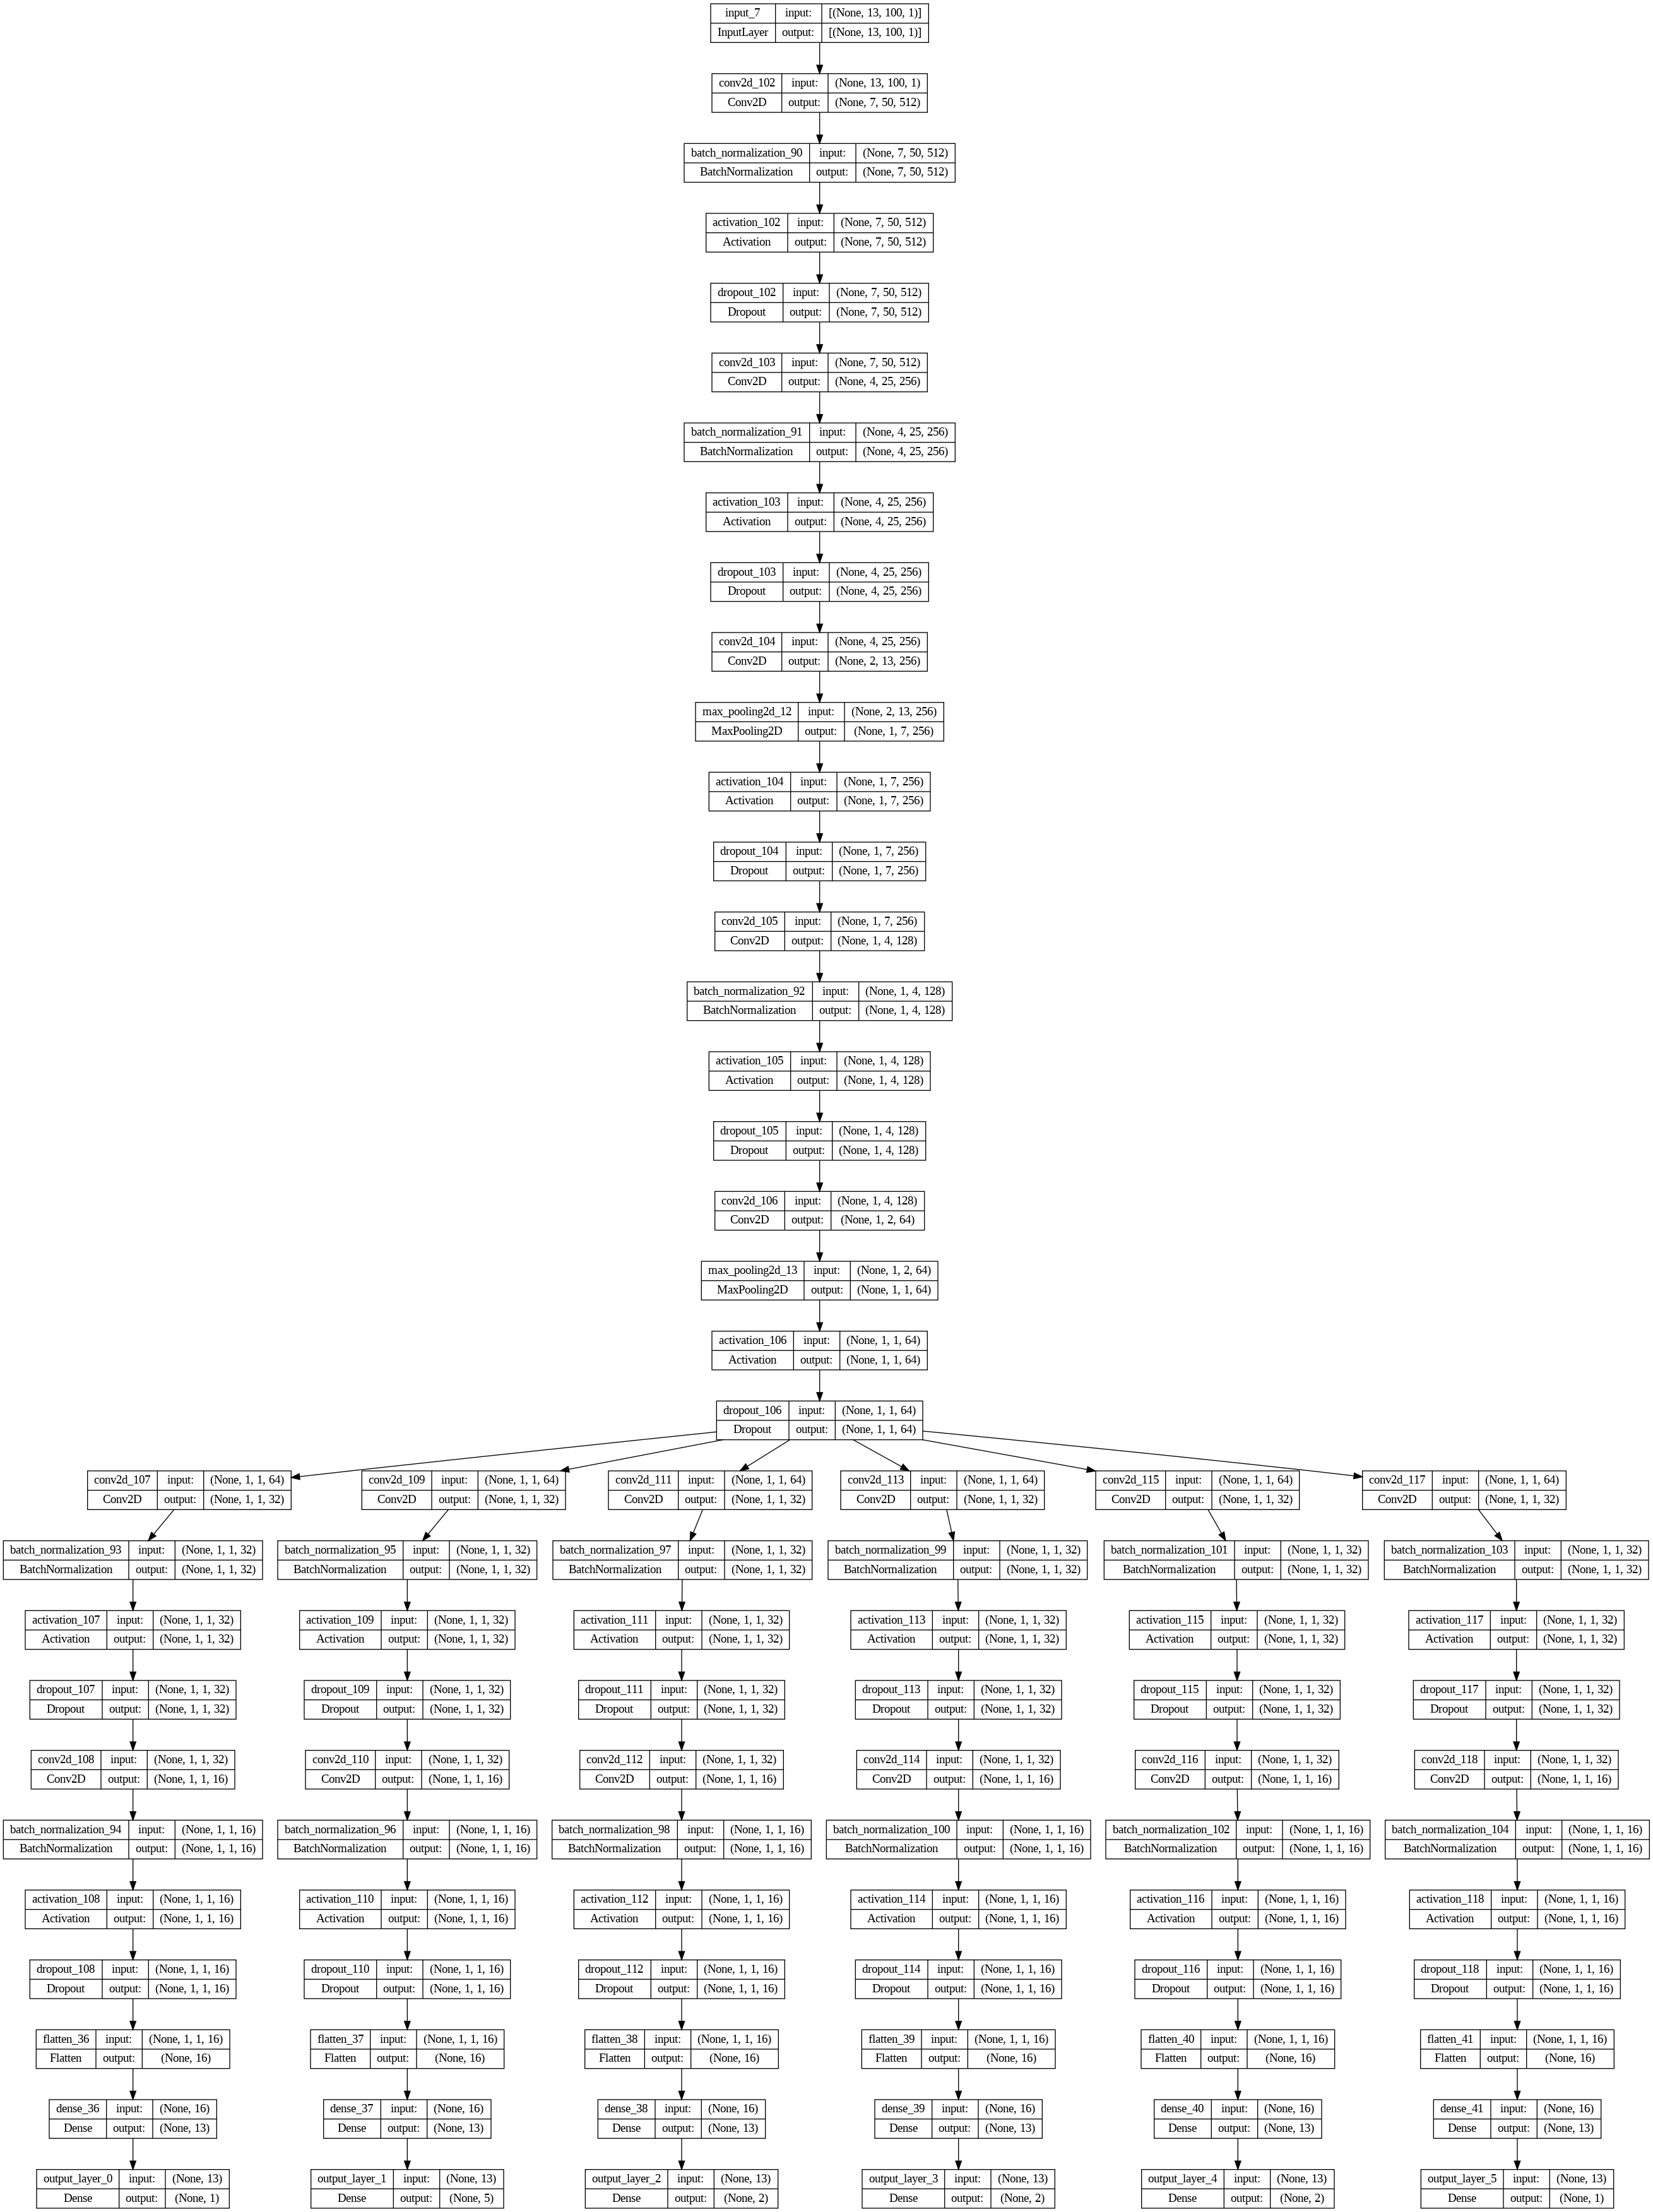

In [ ]:

model = train_inception_model(X_train=1, y_train=1, epochs=220, batch_size=64)
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True,
                          show_layer_names=True, rankdir='TB')


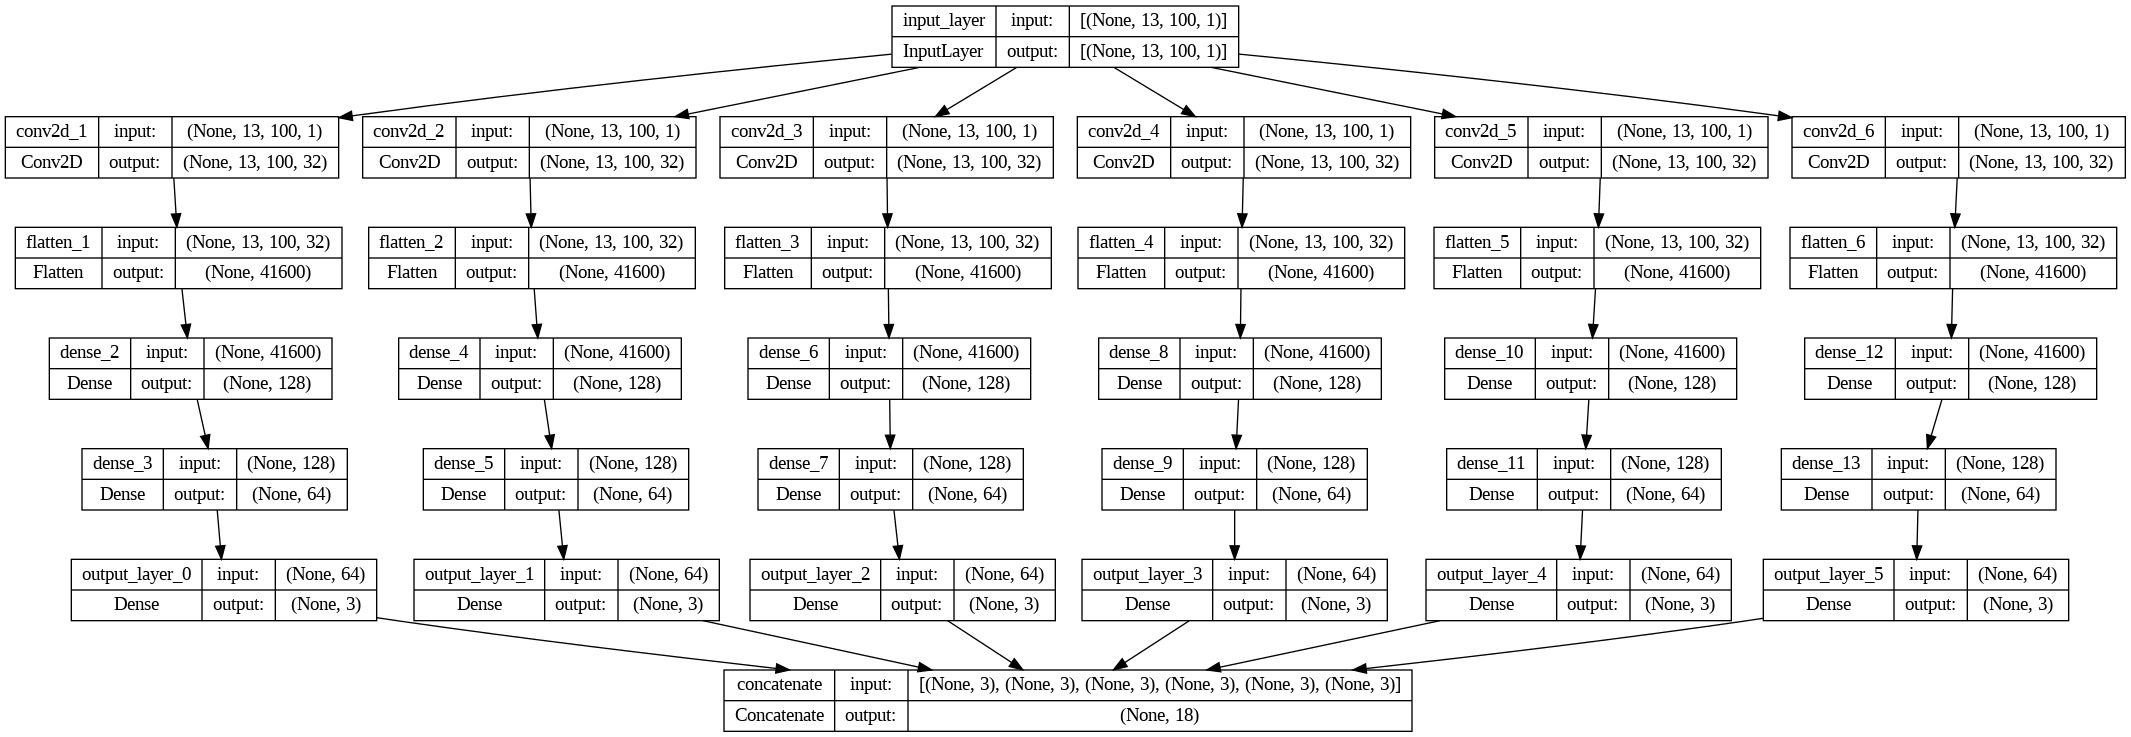

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## model's schematic

loaded data :
(13024, 13, 130, 1) (3257, 13, 130, 1) (13024, 13) (3257, 13)
Original shapes:
(13024, 13, 130, 1) (3257, 13, 130, 1) (13024, 13) (3257, 13)
Balanced and Split train/test shapes:
(2665, 13, 130, 1) (676, 13, 130, 1) (2665,) (676,)
min_samples: 257


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/400
21/21 [==============================] - 23s 133ms/step - loss: 2.7046 - accuracy: 0.0792
Epoch 2/400
21/21 [==============================] - 2s 83ms/step - loss: 2.7110 - accuracy: 0.0728
Epoch 3/400
21/21 [==============================] - 2s 83ms/step - loss: 2.6794 - accuracy: 0.0799
Epoch 4/400
21/21 [==============================] - 2s 83ms/step - loss: 2.6873 - accuracy: 0.0788
Epoch 5/400
21/21 [==============================] - 2s 84ms/step - loss: 2.6895 - accuracy: 0.0777
Epoch 6/400
21/21 [==============================] - 2s 84ms/step - loss: 2.6699 - accuracy: 0.0788
Epoch 7/400
21/21 [==============================] - 2s 86ms/step - loss: 2.6843 - accuracy: 0.0754
Epoch 8/400
21/21 [==============================] - 2s 85ms/step - loss: 2.6688 - accuracy: 0.0795
Epoch 9/400
21/21 [==============================] - 2s 85ms/step - loss: 2.6611 - accuracy: 0.0818
Epoch 10/400
21/21 [==============================] - 2s 85ms/step - loss: 2.6776 - accuracy: 0.07

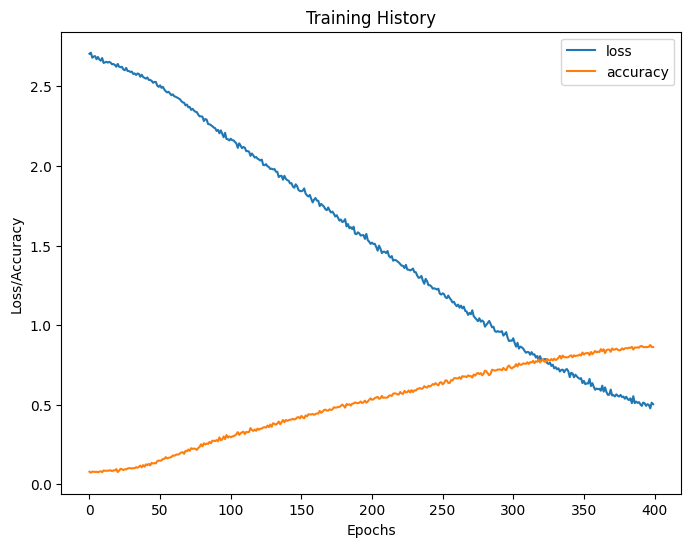

22/22 [==============================] - 0s 5ms/step


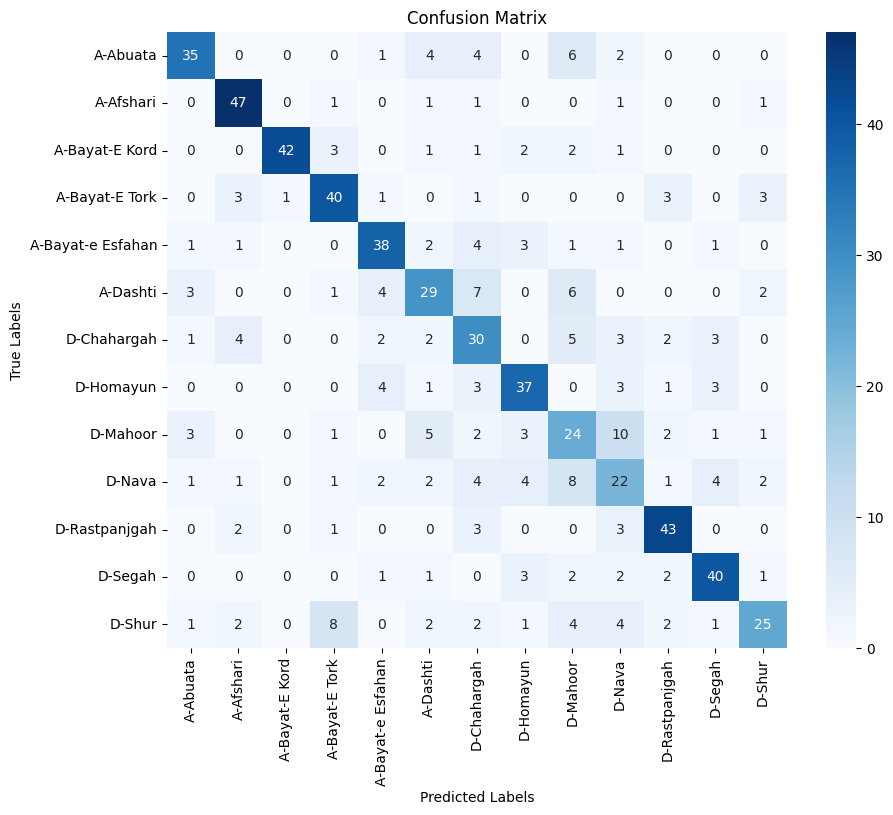

Model saved as model-1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
dataset_number_list = ["1", "2", "3", "4", "5", "6", "7", "8"]
window_D_list = [10, 10, 8, 5, 4, 10, 9, 3]
overlap_list = [5, 2, 0, 0, 0, 5, 3, 0]

dataset_number_list = ["8"]
window_D_list = [3]
overlap_list = [0]


for i, dataset_number in enumerate(dataset_number_list):

  pickle_dis = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}/filterd"
  window_duration = window_D_list[i]
  overlap = overlap_list[i]

  ## unbalance data
  epochs = 220
  batch_size = 128

  # loding data from pickle dis
  X_train, X_test, y_train, y_test = load_data(pickle_dis)

  #traing the model with given data and epochs and batch size
  # model, hist = train_model(X_train, y_train, epochs=epochs, batch_size=batch_size)

  # # evaluating model
  # evaluate_model(model, hist, X_train, y_train, X_test, y_test, pickle_dis,
  #                  window_duration = window_duration, overlap = overlap,
  #                  epochs = epochs, batch_size = batch_size, balansed=False)

  # plot_loss_acc(hist, pickle_dis)

  # plot_Confusion_Matrix(model, X_test, y_test, pickle_dis)

  # model_dir = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}/model"
  # save_model_to_directory(model, model_dir)

  ## balance data
  epochs = 400

  X_train, X_test, y_train, y_test = balance_dataset(X_train, X_test, y_train, y_test)

  model, hist = train_model(X_train, y_train, epochs=epochs, batch_size=batch_size)

  evaluate_model(model, hist, X_train, y_train, X_test, y_test, pickle_dis,
                   window_duration = window_duration, overlap = overlap,
                   epochs = epochs, batch_size = batch_size, balansed=True)

  plot_loss_acc(hist, pickle_dis)

  plot_Confusion_Matrix(model, X_test, y_test, pickle_dis)

  model_dir = f"drive/MyDrive/DDEMS Lab/pickle_dataset/output{dataset_number}/model"
  save_model_to_directory(model, model_dir)


## model's parameters

In [ ]:
model.summary()